<a href="https://colab.research.google.com/github/buckyron/StumbleuponEvergreen/blob/master/stumbleuponevergreen_80_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import nltk
import textblob
import re
import spacy
import unicodedata
import string



In [4]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [5]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [6]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/StumbleUponEvergreen/train.tsv',sep = '\t', header = 0)
df.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.stem.snowball import SnowballStemmer
from nltk import RegexpParser
stemmer = SnowballStemmer("english")
stop_words = stopwords.words("english")



def clean_text(x):

  # remove punctuations.
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)

  # remove stopwords.
  x = ' '.join([word for word in x.split() if word not in stop_words])

  # remove numbers.
  x = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", x)
  x = re.sub(r'\d+', '', x)

  # remove urls.
  x = re.sub(r'(http|ftp|https|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)
  
  # remove mail ids.
  x = re.sub(r'\S*@\S*\s?', '', x)
  
  # remove accented characters.
  x = unicodedata.normalize('NFKD',x).encode('ascii', 'ignore').decode('utf-8', 'ignore')

  # remove nouns and delimeters.
  tagged_sentence = nltk.tag.pos_tag(x.split())
  x = ' '.join([word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS' and tag != 'NNS' and tag != 'NN' and tag != 'DT' and tag != 'WP' and tag != 'PRP' and tag != 'PRPS'])
  
  # lemmatize the sentences.
  lemmatizer=WordNetLemmatizer()
  x = ' '.join([lemmatizer.lemmatize(word) for word in x.split()])

  return x






In [ ]:
df['clean_boilerplate'] = df.boilerplate.apply(clean_text)

In [ ]:
# write the clean data to a new csv.
df.to_csv('/content/drive/MyDrive/StumbleUponEvergreen/clean_train.csv')

In [8]:
df = pd.read_csv('/content/drive/MyDrive/StumbleUponEvergreen/clean_train.csv',sep = ',', header = 0)
df.head()

,Unnamed: 0,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,clean_boilerplate
0,0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,ibm holographic breathing body stand outside c...
1,1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,title That fully electronic futuristic startin...
2,2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,fight flu cold flu Apples popular diet one ant...
3,3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1,There lot sleep took long fall easily awaken s...
4,4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,title coolest seen curious buying stylish top ...


In [9]:
# shuffle the data rows.
from sklearn.utils import shuffle
df = shuffle(df)

In [10]:
# convert the dataframes to list.
boilerplates =list(df['clean_boilerplate'].astype(str))
labels = list(df.label)
print(labels[0])
print(boilerplates[1])



1
body touchy personal provide easily swap meal particularly like one And tried find easy make worth cooking begin marked new added within past devolve


In [11]:
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 5916 #80 percent of the dataset.
validation_size = 7025 #15 percent of the dataset.

In [12]:
# split the dataset into train, validation and test.
training_sentences = boilerplates[0:training_size]
validation_sentences = boilerplates[training_size:validation_size]
testing_sentences = boilerplates[validation_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:validation_size]
testing_labels = labels[validation_size:]

In [13]:
# create a tokenizer and fit it to the training sentences.
tokenizer = Tokenizer(num_words=30000, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [14]:
word_index = tokenizer.word_index
print(len(word_index))


32673


In [ ]:
# Fetch word vectors from glove.
embeddings_index = {}
f = open('/content/drive/MyDrive/StumbleUponEvergreen/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['cool']

array([-0.74587 , -0.31105 ,  0.50803 , -0.29089 , -0.27585 ,  0.36639 ,
        0.11195 ,  0.064536, -0.49929 ,  0.24547 ,  0.16176 , -0.52799 ,
        0.006528, -0.25769 ,  0.13147 , -0.05776 , -0.43521 , -0.38571 ,
        0.095668, -0.037963,  0.10614 ,  0.58842 ,  0.13133 , -0.72813 ,
       -0.12345 ,  0.84321 , -0.51126 , -0.54044 , -0.43643 , -0.17442 ,
       -0.13725 ,  0.45419 , -0.32037 ,  0.10308 , -0.19441 ,  0.87384 ,
        0.44916 , -0.72491 ,  0.40962 , -0.82056 , -0.080839, -1.0468  ,
       -0.32499 , -0.38805 ,  0.24453 , -0.15281 , -0.23598 ,  0.22905 ,
        0.97877 , -1.1883  , -0.023652, -0.32838 ,  0.16727 ,  0.59475 ,
       -0.19604 , -2.441   ,  0.55152 ,  0.40888 ,  0.57289 , -0.070599,
        0.18115 ,  1.0243  , -1.0689  ,  0.29498 ,  0.79422 ,  0.28825 ,
        0.80208 , -0.30532 ,  0.27398 , -0.78987 ,  0.4938  , -0.090447,
        0.11786 ,  0.11613 ,  0.055007,  0.44122 ,  0.22263 , -0.31549 ,
        1.088   , -0.12486 ,  0.43743 , -0.096397, 

In [ ]:
# create an embedding matrix with the word index and the word vectors we fetched.
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# create and pad training, validation and testing sequences.
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(16,  kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer= tf.keras.optimizers.SGD(learning_rate= 0.01),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3169100   
_________________________________________________________________
dropout_24 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 100, 32)           14976     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)               

In [ ]:
with tf.device('/device:GPU:0'):
  num_epochs = 100
  training_padded = np.array(training_padded)
  training_labels = np.array(training_labels)
  validation_padded = np.array(validation_padded)
  validation_labels = np.array(validation_labels)
  history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=1)


Epoch 1/100
185/185 [==============================] - 9s 24ms/step - loss: 0.7046 - accuracy: 0.5067 - val_loss: 0.6863 - val_accuracy: 0.5690
Epoch 2/100
185/185 [==============================] - 3s 16ms/step - loss: 0.6974 - accuracy: 0.5047 - val_loss: 0.6856 - val_accuracy: 0.5798
Epoch 3/100
185/185 [==============================] - 3s 17ms/step - loss: 0.6944 - accuracy: 0.5195 - val_loss: 0.6807 - val_accuracy: 0.5996
Epoch 4/100
185/185 [==============================] - 3s 17ms/step - loss: 0.6934 - accuracy: 0.5412 - val_loss: 0.6779 - val_accuracy: 0.6023
Epoch 5/100
185/185 [==============================] - 3s 17ms/step - loss: 0.6901 - accuracy: 0.5268 - val_loss: 0.6735 - val_accuracy: 0.6150
Epoch 6/100
185/185 [==============================] - 3s 18ms/step - loss: 0.6817 - accuracy: 0.5535 - val_loss: 0.6691 - val_accuracy: 0.6411
Epoch 7/100
185/185 [==============================] - 3s 17ms/step - loss: 0.6837 - accuracy: 0.5575 - val_loss: 0.6608 - val_accuracy:

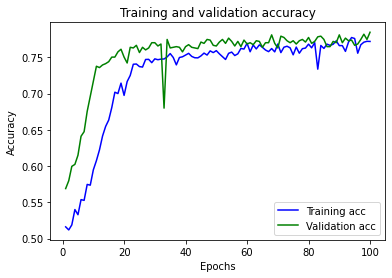

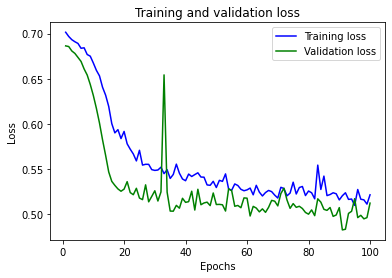

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
loss, accuracy = model.evaluate(testing_padded, testing_labels)

12/12 [==============================] - 0s 12ms/step - loss: 0.4895 - accuracy: 0.8081


In [ ]:
# save the model.
model.save('/content/drive/MyDrive/StumbleUponEvergreen/glove_model.h5')

In [17]:
model = tf.keras.models.load_model('/content/drive/MyDrive/StumbleUponEvergreen/glove_model.h5')

In [34]:
# Fetch test data.
df2 = pd.read_csv('/content/drive/MyDrive/StumbleUponEvergreen/test.tsv',sep = '\t', header = 0)
df2.head()


,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,0.489572,0.0,0,0.067143,0,0.230285,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597
1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,0.782051,0.0,0,0.042857,0,0.365962,0.080000,?,1,62,0,382,39,2,0.128205,0.176471
2,http://www.xcelerationfitness.com/treadmills.html,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st...",?,?,2.269565,0.495726,0.384615,0.170940,0.170940,1.250000,0.0,0,0.058824,0,0.161901,10.000000,?,1,42,0,2420,117,1,0.581197,0.125000
3,http://www.bloomberg.com/news/2012-02-06/syria...,7640,"{""title"":""Father s Tactics Used by Assad to Cr...",culture_politics,0.90259,2.523490,0.705502,0.346278,0.122977,0.090615,0.449366,0.0,0,0.058081,0,0.146593,0.005964,1,1,41,0,5559,309,10,0.038835,0.063126
4,http://www.wired.com/gadgetlab/2011/12/stem-tu...,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui...",science_technology,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,0.453757,0.0,0,0.093023,0,0.244141,0.035714,1,0,34,0,2209,155,10,0.096774,0.065341


In [35]:
# clean data.
df2['clean_boilerplate'] = df2.boilerplate.apply(clean_text)

In [36]:
# write the clean data to a new csv.
df2.to_csv('/content/drive/MyDrive/StumbleUponEvergreen/clean_test.csv')

In [38]:
df2 = pd.read_csv('/content/drive/MyDrive/StumbleUponEvergreen/clean_test.csv',sep = ',', header = 0)
df2.head()

,Unnamed: 0,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,clean_boilerplate
0,0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,0.489572,0.0,0,0.067143,0,0.230285,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597,usually buy enchilada sauce Yes knew making ne...
1,1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,0.782051,0.0,0,0.042857,0,0.365962,0.080000,?,1,62,0,382,39,2,0.128205,0.176471,grenade ar funny se best funny internet funny ...
2,2,http://www.xcelerationfitness.com/treadmills.html,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st...",?,?,2.269565,0.495726,0.384615,0.170940,0.170940,1.250000,0.0,0,0.058824,0,0.161901,10.000000,?,1,42,0,2420,117,1,0.581197,0.125000,stair url
3,3,http://www.bloomberg.com/news/2012-02-06/syria...,7640,"{""title"":""Father s Tactics Used by Assad to Cr...",culture_politics,0.90259,2.523490,0.705502,0.346278,0.122977,0.090615,0.449366,0.0,0,0.058081,0,0.146593,0.005964,1,1,41,0,5559,309,10,0.038835,0.063126,Used father used assad threatening Syrian al I...
4,4,http://www.wired.com/gadgetlab/2011/12/stem-tu...,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui...",science_technology,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,0.453757,0.0,0,0.093023,0,0.244141,0.035714,1,0,34,0,2209,155,10,0.096774,0.065341,title turn juicy stem turn lime body turn spra...


In [22]:
# create and pad test sequences.
prediction_sentences = list(df2['clean_boilerplate'].astype(str))
print(prediction_sentences[0])

usually buy enchilada sauce Yes knew making never found really happy tried several good So stuck canned stuff recently talking lived know Mexican asked made told gave exact decided give really good best made great think even better canned sauce could spicier But like enchilada always add chili like really spicy thought really good like change two called green used regular thought worked great probably continue make also pureed wanted smooth sauce If want together blend pretty frugal sauce great make even frugal tomato sauce chopped green undrained cup chopped chili dried oregano minced blender Then place saucepan heated desired free free Like homemade enchilada sauce came friend spent several mexico url homemade enchilada


In [23]:
prediction_sequences = tokenizer.texts_to_sequences(prediction_sentences)
prediction_padded = pad_sequences(prediction_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [24]:
# make predictions.
prediction = model.predict(prediction_padded, verbose=0)

In [25]:
prediction = np.around(prediction)
print(prediction)

[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [26]:
# create dataframe of predictions and urlid's.
pred_df = pd.DataFrame(prediction, columns=['label'])
url_df = pd.DataFrame(data = df2['urlid'], columns=['urlid'])
url_df.reset_index(drop = True, inplace = True)
pred_df.reset_index(drop = True, inplace = True)
len(pred_df)


3171

In [27]:
url_df.head()

,urlid
0,5865
1,782
2,6962
3,7640
4,3589


In [28]:
submission_df = pd.concat([url_df, pred_df], axis=1)
submission_df.head()

,urlid,label
0,5865,1.0
1,782,0.0
2,6962,1.0
3,7640,0.0
4,3589,1.0


In [33]:
# create a csv of tthe results.
submission_df.to_csv('/content/drive/MyDrive/StumbleUponEvergreen/submit.csv',sep= '\t', index=False)